In [13]:
# UT3 EXTRA - Feature Engineering y churn en Online Retail II (UCI)
# Caso: predicción de clientes en riesgo de abandono

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (8,5)

# 1) Carga del dataset real Online Retail II (UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"

# Usamos el año 2010-2011 (más completo)
df_raw = pd.read_excel(url, sheet_name="Year 2010-2011")

df_raw.head(), df_raw.shape

(  Invoice StockCode                          Description  Quantity  \
 0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1  536365     71053                  WHITE METAL LANTERN         6   
 2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  Price  Customer ID         Country  
 0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
 1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
 2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
 3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
 4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  ,
 (541910, 8))

In [14]:
# 2) Limpieza básica

df = df_raw.copy()

# Renombrar columnas a un formato más cómodo (por si vienen con espacios)
df.columns = [
    "InvoiceNo", "StockCode", "Description", "Quantity",
    "InvoiceDate", "UnitPrice", "CustomerID", "Country"
]

# Eliminar filas sin CustomerID
df = df.dropna(subset=["CustomerID"])

# Asegurar tipos
df["CustomerID"] = df["CustomerID"].astype(int)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Filtrar cantidades y precios positivos
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Crear columna de ingreso por línea
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

df.head(), df.shape

(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
 0 2010-12-01 08:26:00       2.55       17850  United Kingdom    15.30  
 1 2010-12-01 08:26:00       3.39       17850  United Kingdom    20.34  
 2 2010-12-01 08:26:00       2.75       17850  United Kingdom    22.00  
 3 2010-12-01 08:26:00       3.39       17850  United Kingdom    20.34  
 4 2010-12-01 08:26:00       3.39       17850  United Kingdom    20.34  ,
 (397885, 9))

In [15]:
# 3) Construcción de vista a nivel cliente + definición de churn

# Fecha de "corte" (snapshot): última fecha disponible
snapshot_date = df["InvoiceDate"].max()
snapshot_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# Agregación a nivel cliente

customer = (
    df
    .groupby("CustomerID")
    .agg(
        first_purchase=("InvoiceDate", "min"),
        last_purchase=("InvoiceDate", "max"),
        num_invoices=("InvoiceNo", "nunique"),
        num_items=("Quantity", "sum"),
        num_products=("StockCode", "nunique"),
        total_revenue=("Revenue", "sum"),
        avg_unit_price=("UnitPrice", "mean"),
        country=("Country", lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0])
    )
    .reset_index()
)

customer["recency_days"] = (snapshot_date - customer["last_purchase"]).dt.days
customer["tenure_days"] = (customer["last_purchase"] - customer["first_purchase"]).dt.days.clip(lower=1)

# Definimos churn: clientes con más de 90 días sin comprar
customer["churn"] = (customer["recency_days"] > 90).astype(int)

customer.head()

,CustomerID,first_purchase,last_purchase,num_invoices,num_items,num_products,total_revenue,avg_unit_price,country,recency_days,tenure_days,churn
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,1,74215,1,77183.60,1.040000,United Kingdom,325,1,1
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,7,2458,103,4310.00,2.644011,Iceland,1,365,0
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,4,2341,22,1797.24,5.764839,Finland,74,282,0
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,1,631,73,1757.55,8.289041,Italy,18,1,0
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,1,197,17,334.40,3.841176,Norway,309,1,1


In [17]:
# 4) Feature engineering de comportamiento

cust_fe = customer.copy()

# RFM básico
cust_fe["frequency"] = cust_fe["num_invoices"]
cust_fe["monetary"] = cust_fe["total_revenue"]
cust_fe["recency"] = cust_fe["recency_days"]

# Ratios y transformaciones
cust_fe["items_per_invoice"] = cust_fe["num_items"] / cust_fe["num_invoices"]
cust_fe["revenue_per_invoice"] = cust_fe["total_revenue"] / cust_fe["num_invoices"]
cust_fe["revenue_per_day"] = cust_fe["total_revenue"] / cust_fe["tenure_days"]

# Transformaciones logarítmicas para estabilizar distribuciones sesgadas
for col in ["monetary", "revenue_per_invoice", "revenue_per_day"]:
    cust_fe[f"log_{col}"] = np.log1p(cust_fe[col])

# Engagement simple: combinación de recency y frecuencia
cust_fe["engagement_score"] = (
    (cust_fe["frequency"] / cust_fe["frequency"].max()) * 0.5
    + ((cust_fe["tenure_days"] - cust_fe["recency"]) / cust_fe["tenure_days"]).clip(0,1) * 0.5
)

cust_fe[[
    "CustomerID", "recency", "frequency", "monetary",
    "items_per_invoice", "revenue_per_invoice", "revenue_per_day",
    "log_monetary", "log_revenue_per_invoice",
    "log_revenue_per_day", "engagement_score", "churn"
]].head()

,CustomerID,recency,frequency,monetary,items_per_invoice,revenue_per_invoice,revenue_per_day,log_monetary,log_revenue_per_invoice,log_revenue_per_day,engagement_score,churn
0,12346,325,1,77183.60,74215.000000,77183.600000,77183.600000,11.253955,11.253955,11.253955,0.002392,1
1,12347,1,7,4310.00,351.142857,615.714286,11.808219,8.368925,6.424406,2.550087,0.515377,0
2,12348,74,4,1797.24,585.250000,449.310000,6.373191,7.494564,6.109936,1.997851,0.378364,0
3,12349,18,1,1757.55,631.000000,1757.550000,1757.550000,7.472245,7.472245,7.472245,0.002392,0
4,12350,309,1,334.40,197.000000,334.400000,334.400000,5.815324,5.815324,5.815324,0.002392,1


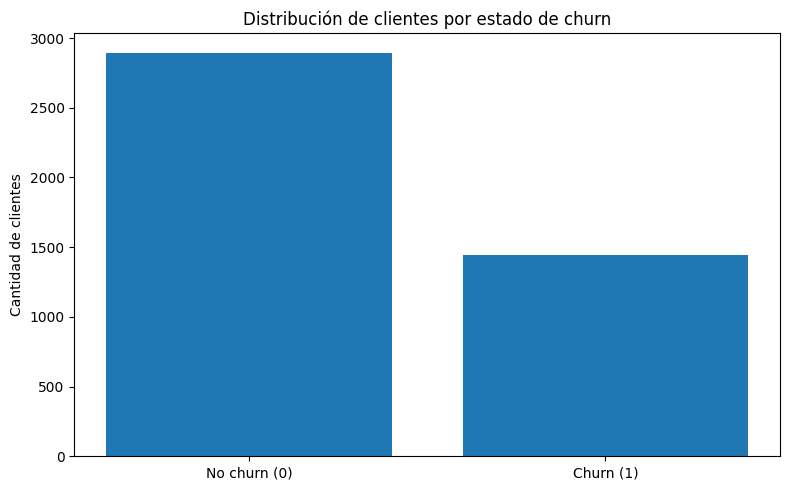

(churn
 0    2893
 1    1445
 Name: count, dtype: int64,
 churn
 0    0.666897
 1    0.333103
 Name: count, dtype: float64)

In [18]:
# 5) Visualización 1: balance de clases (churn vs no churn)

churn_counts = cust_fe["churn"].value_counts().sort_index()

plt.figure()
plt.bar(["No churn (0)", "Churn (1)"], churn_counts.values)
plt.title("Distribución de clientes por estado de churn")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.savefig("ut3_churn_class_balance.png", dpi=120)
plt.show()

churn_counts, churn_counts / churn_counts.sum()

<Figure size 800x500 with 0 Axes>

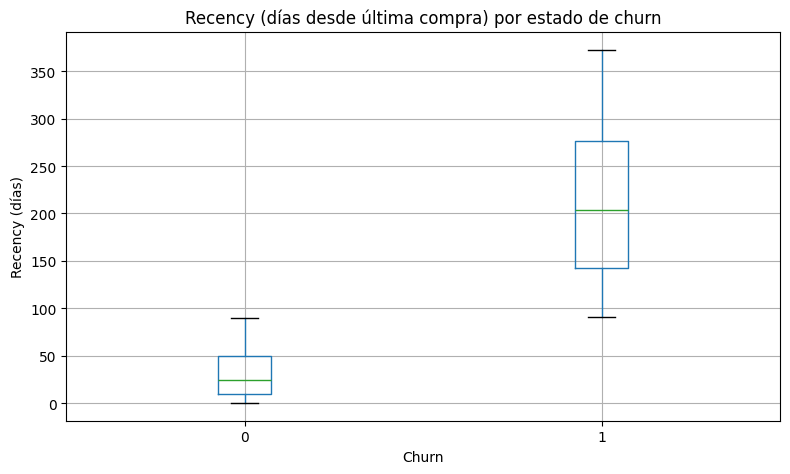

In [19]:
# 6) Visualización 2: recency por churn (boxplot)

plt.figure()
cust_fe.boxplot(column="recency", by="churn")
plt.title("Recency (días desde última compra) por estado de churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Recency (días)")
plt.tight_layout()
plt.savefig("ut3_churn_recency_boxplot.png", dpi=120)
plt.show()

In [20]:
# 7) Preparación para modelado supervisado (predicción de churn)

# Seleccionamos features numéricas + país como categórica
num_cols = [
    "recency", "frequency", "monetary",
    "items_per_invoice", "revenue_per_invoice",
    "revenue_per_day", "log_monetary",
    "log_revenue_per_invoice", "log_revenue_per_day",
    "engagement_score", "num_products", "tenure_days"
]

cat_cols = ["country"]

X_num = cust_fe[num_cols].copy()
X_cat = pd.get_dummies(cust_fe[cat_cols], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = cust_fe["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((3253, 48), (1085, 48))

In [21]:
# 8) Entrenamiento de modelo de churn (Random Forest)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       1.00      1.00      1.00       361

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085

[[724   0]
 [  0 361]]


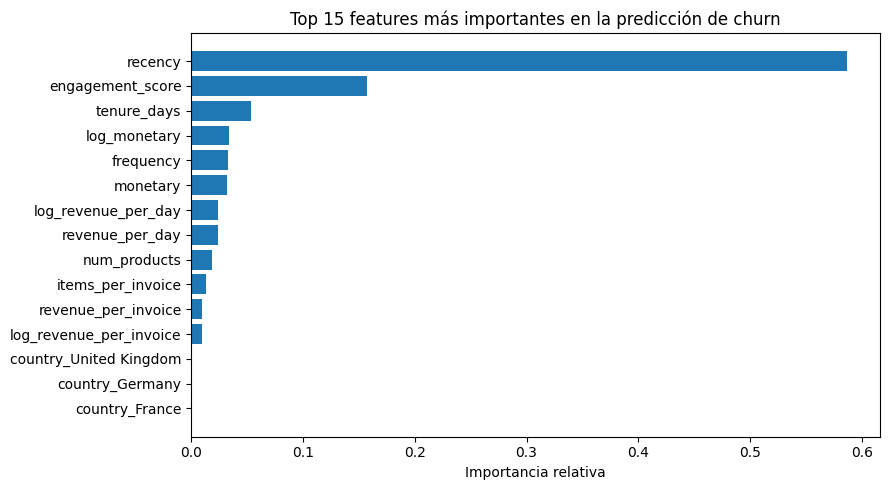

,feature,importance
0,recency,0.586915
9,engagement_score,0.157616
11,tenure_days,0.053240
6,log_monetary,0.033724
1,frequency,0.032633
2,monetary,0.031621
8,log_revenue_per_day,0.024174
5,revenue_per_day,0.024169
10,num_products,0.018621
3,items_per_invoice,0.013157


In [22]:
# 9) Importancia de features

importances = rf.feature_importances_
feat_imp = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(9,5))
plt.barh(feat_imp["feature"], feat_imp["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa")
plt.title("Top 15 features más importantes en la predicción de churn")
plt.tight_layout()
plt.savefig("ut3_churn_feature_importance.png", dpi=120)
plt.show()

feat_imp

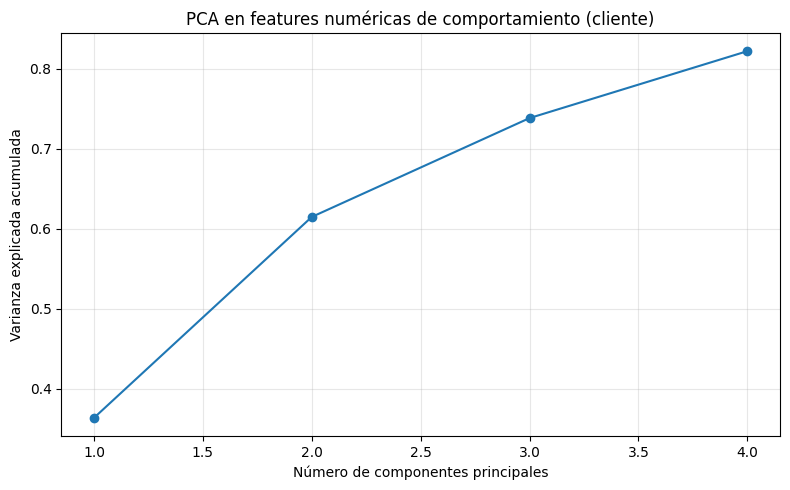

array([0.36343991, 0.25125574, 0.12361751, 0.08367803])

In [23]:
# 10) PCA sobre features numéricas para explorar estructura y clusters de churn

num_data = cust_fe[num_cols].copy()

from sklearn.preprocessing import StandardScaler as SkStandardScaler

scaler_pca = SkStandardScaler()
num_scaled = scaler_pca.fit_transform(num_data)

pca = PCA(n_components=4, random_state=42)
pca.fit(num_scaled)

explained_var = pca.explained_variance_ratio_

plt.figure()
plt.plot(range(1, len(explained_var) + 1),
         np.cumsum(explained_var),
         marker="o")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA en features numéricas de comportamiento (cliente)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("ut3_churn_pca_scree.png", dpi=120)
plt.show()

explained_var

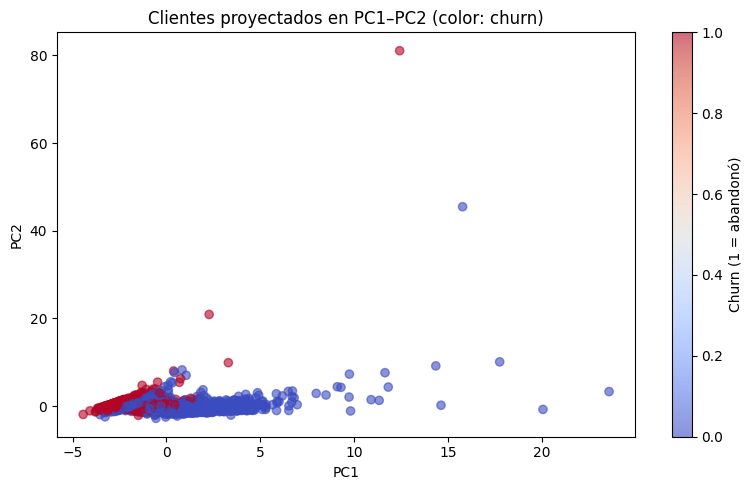

In [24]:
# 11) Proyección de clientes en PC1–PC2 coloreada por churn

pcs = pca.transform(num_scaled)
pc1 = pcs[:, 0]
pc2 = pcs[:, 1]

plt.figure()
scatter = plt.scatter(
    pc1, pc2,
    c=cust_fe["churn"], cmap="coolwarm", alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clientes proyectados en PC1–PC2 (color: churn)")
cbar = plt.colorbar(scatter)
cbar.set_label("Churn (1 = abandonó)")
plt.tight_layout()
plt.savefig("ut3_churn_pca_scatter.png", dpi=120)
plt.show()